# LIBRARIES

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Image processing libraries
import cv2
import skimage
from skimage.transform import resize

# Scikit-learn for machine learning operations
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Metrics for evaluation
from sklearn import metrics


# DATA LOADING AND PREPROCESSING

In [ ]:
#Load the Dataset
dataset_path = "/content/isl33"
class_names = sorted(os.listdir('/content/isl33'))

In [ ]:
from os import listdir
total_signs=sorted(listdir("/content/isl33"))
print(total_signs)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'w', 'x', 'y', 'z']


In [ ]:
import os
from collections import defaultdict
from matplotlib.image import imread

path = "/content/isl33"
total_signs = os.listdir(path)

resolution_count = defaultdict(int)

for directory in total_signs:
    directory_path = os.path.join(path, directory)
    for filename in os.listdir(directory_path):
        image_path = os.path.join(directory_path, filename)
        try:
            img = imread(image_path)
            resolution = img.shape[:2]  # Extract resolution (height, width)
            resolution_count[resolution] += 1
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

print("Resolution Counts:")
for resolution, count in resolution_count.items():
    print(f"Resolution: {resolution}, Count: {count}")


Resolution Counts:
Resolution: (160, 165), Count: 190
Resolution: (168, 173), Count: 180
Resolution: (166, 171), Count: 138
Resolution: (170, 175), Count: 154
Resolution: (176, 180), Count: 2
Resolution: (162, 167), Count: 152
Resolution: (158, 163), Count: 164
Resolution: (156, 161), Count: 206
Resolution: (170, 173), Count: 1
Resolution: (172, 177), Count: 183
Resolution: (182, 182), Count: 1
Resolution: (154, 159), Count: 167
Resolution: (178, 183), Count: 160
Resolution: (174, 179), Count: 165
Resolution: (164, 169), Count: 153
Resolution: (176, 181), Count: 140
Resolution: (158, 162), Count: 2
Resolution: (182, 187), Count: 147
Resolution: (170, 172), Count: 1
Resolution: (164, 163), Count: 1
Resolution: (168, 171), Count: 2
Resolution: (154, 147), Count: 1
Resolution: (168, 167), Count: 1
Resolution: (160, 151), Count: 2
Resolution: (182, 184), Count: 1
Resolution: (152, 157), Count: 190
Resolution: (168, 168), Count: 1
Resolution: (172, 174), Count: 1
Resolution: (170, 170), Cou

In [ ]:
import pandas as pd
import os

# Define the base directory
train_folder = "/content/isl33"


# Constructing a list of dictionaries containing file paths and corresponding labels
all_data = [{'label': folder, 'path': os.path.join(train_folder, folder, f)}
            for folder in os.listdir(train_folder)
            for f in os.listdir(os.path.join(train_folder, folder))
            if os.path.isfile(os.path.join(train_folder, folder, f))]

# Creating a DataFrame from the list of dictionaries
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,y,/content/isl33/y/292.png
1,y,/content/isl33/y/157.png
2,y,/content/isl33/y/103.png
3,y,/content/isl33/y/89.png
4,y,/content/isl33/y/130.png
...,...,...
10747,q,/content/isl33/q/147.png
10748,q,/content/isl33/q/172.png
10749,q,/content/isl33/q/27.png
10750,q,/content/isl33/q/108.png


In [ ]:
train_data, test_data = train_test_split(data_df, test_size=0.1, random_state=42, stratify=data_df['label'])
train_data, validation_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['label'])

# Display the number of samples in each set
print("Training samples:", len(train_data))
print("Validation samples:", len(validation_data))
print("Test samples:", len(test_data))

Training samples: 7740
Validation samples: 1936
Test samples: 1076


In [ ]:
# Define image dimensions and batch size
img_width, img_height = 75, 75
batch_size = 128

# Define column names
y_col = 'label'
x_col = 'path'

# Number of classes
no_of_classes = len(data_df[y_col].unique())

# Image data generators
datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Flow from dataframe for training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='path',
    y_col='label',
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

# Flow from dataframe for test data
validation_generator = datagen.flow_from_dataframe(
    dataframe=validation_data,
    x_col='path',
    y_col='label',
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)
test_datagen = ImageDataGenerator(rescale=1./255)
# Flow from dataframe for test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='path',
    y_col='label',
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 7740 validated image filenames belonging to 33 classes.
Found 1936 validated image filenames belonging to 33 classes.
Found 1076 validated image filenames belonging to 33 classes.


# CUSTOM CNN

In [ ]:
Early_Stopper = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")
Checkpoint_Model = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      filepath="./modelcheck")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

cnn_model = Sequential()

cnn_model.add(Conv2D(24,(3,3),activation="relu",input_shape=(img_width, img_height, 3)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
cnn_model.add(Dropout(0.3))
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
cnn_model.add(Dropout(0.3))
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
cnn_model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
cnn_model.add(Dropout(0.3))
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
cnn_model.add(Dropout(0.3))
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Flatten())
cnn_model.add(Dense(2352,activation="relu"))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(33,activation="softmax"))

In [ ]:
cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_112 (Conv2D)         (None, 73, 73, 24)        672       
                                                                 
 batch_normalization_97 (Ba  (None, 73, 73, 24)        96        
 tchNormalization)                                               
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 36, 36, 24)        0         
 ng2D)                                                           
                                                                 
 conv2d_113 (Conv2D)         (None, 36, 36, 64)        13888     
                                                                 
 dropout_18 (Dropout)        (None, 36, 36, 64)        0         
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 18, 18, 64)       

In [ ]:
# Define parameters
learning_rate = 0.0001

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = cnn_model.fit(train_generator,
                    epochs=10,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[Early_Stopper,Checkpoint_Model],
                    shuffle=True)

Epoch 1/10
61/61 [==============================] - 17s 255ms/step - loss: 1.7478 - accuracy: 0.4355 - val_loss: 3.2162 - val_accuracy: 0.2505
Epoch 2/10
61/61 [==============================] - 16s 259ms/step - loss: 1.2814 - accuracy: 0.5752 - val_loss: 3.0593 - val_accuracy: 0.4876
Epoch 3/10
61/61 [==============================] - 16s 261ms/step - loss: 0.9339 - accuracy: 0.6810 - val_loss: 2.8605 - val_accuracy: 0.5021
Epoch 4/10
61/61 [==============================] - 17s 276ms/step - loss: 0.6834 - accuracy: 0.7674 - val_loss: 2.5567 - val_accuracy: 0.6204
Epoch 5/10
61/61 [==============================] - 17s 271ms/step - loss: 0.5591 - accuracy: 0.8094 - val_loss: 2.2837 - val_accuracy: 0.6746
Epoch 6/10
61/61 [==============================] - 17s 280ms/step - loss: 0.4342 - accuracy: 0.8488 - val_loss: 2.0109 - val_accuracy: 0.7464
Epoch 7/10
61/61 [==============================] - 17s 277ms/step - loss: 0.3878 - accuracy: 0.8651 - val_loss: 1.6590 - val_accuracy: 0.8466

In [ ]:
cnn_model.save('33-cnn-newisl.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


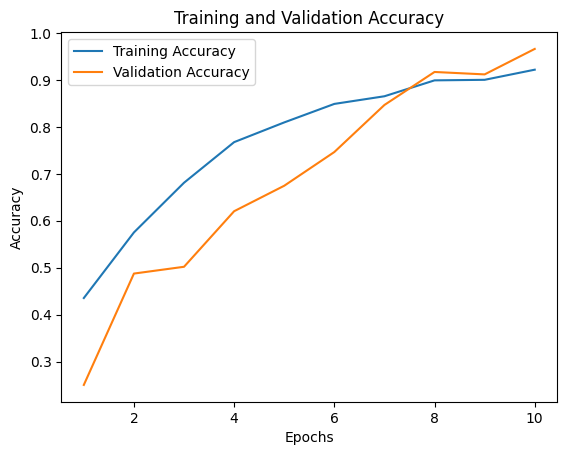

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy and loss from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


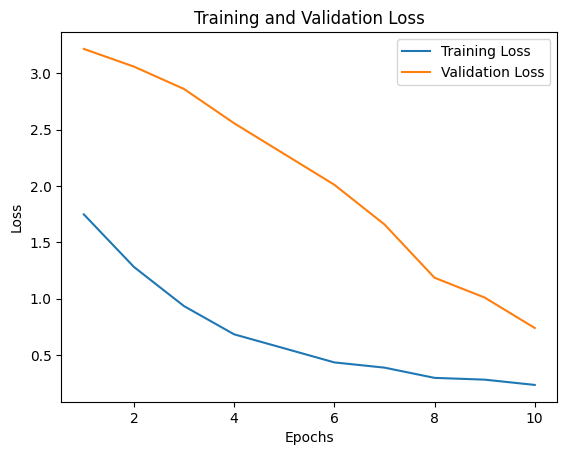

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score

# Generate predictions on test data
predictions = cnn_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes) * 100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted') * 100
recall = recall_score(true_classes, predicted_classes, average='weighted') * 100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


9/9 [==============================] - 1s 104ms/step
Accuracy: 94.9814126394052
Precision: 96.21933696438035
Recall: 94.9814126394052
F1-score: 95.59636734732595


9/9 [==============================] - 1s 105ms/step


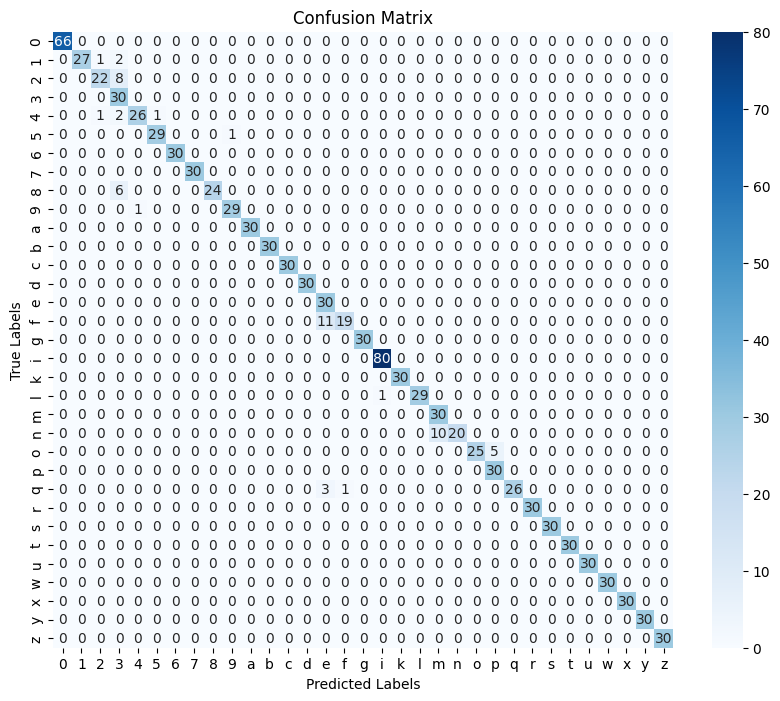

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have already trained your model and stored it in a variable named 'model'

# Generate predictions
predictions = cnn_model.predict(test_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from test_generator
true_labels = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 305ms/step


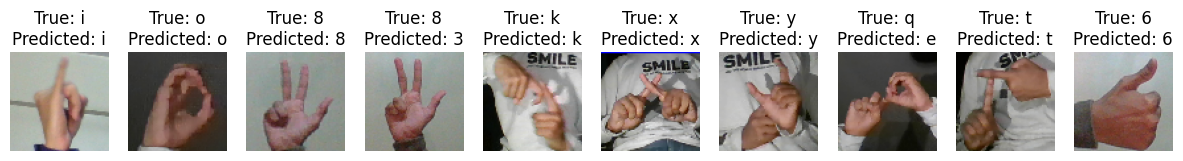

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = cnn_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# INCEPTIONV3

In [ ]:
from tensorflow.keras.applications import InceptionV3
# Load the  inceptionv3 model pre-trained on ImageNet without the top layer
base_model1 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the convolutional layers
base_model1.trainable = False

# Print model summary
base_model1.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 37, 37, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 37, 37, 32)           96        ['conv2d_6[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 37, 37, 32)           0         ['batch_normalizati

In [ ]:

inceptionv3_model = models.Sequential([
    base_model1,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(33, activation='softmax')
])


In [ ]:
inceptionv3_model.summary().

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 33)                16929     
                                                                 
Total params: 22868801 (87.24 MB)
Trainable params: 1066017 (4.07 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
# Define parameters
classes = 33
epochs = 10
learning_rate = 0.0001

# Compile the model
inceptionv3_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history1 = inceptionv3_model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    shuffle=True)

Epoch 1/10
61/61 [==============================] - 23s 298ms/step - loss: 3.2533 - accuracy: 0.1702 - val_loss: 2.2088 - val_accuracy: 0.4742
Epoch 2/10
61/61 [==============================] - 17s 274ms/step - loss: 2.0928 - accuracy: 0.4231 - val_loss: 1.4361 - val_accuracy: 0.6777
Epoch 3/10
61/61 [==============================] - 16s 269ms/step - loss: 1.5607 - accuracy: 0.5687 - val_loss: 1.0364 - val_accuracy: 0.7645
Epoch 4/10
61/61 [==============================] - 16s 268ms/step - loss: 1.2508 - accuracy: 0.6453 - val_loss: 0.8594 - val_accuracy: 0.8084
Epoch 5/10
61/61 [==============================] - 16s 267ms/step - loss: 1.0688 - accuracy: 0.6947 - val_loss: 0.7037 - val_accuracy: 0.8368
Epoch 6/10
61/61 [==============================] - 17s 282ms/step - loss: 0.9299 - accuracy: 0.7345 - val_loss: 0.6352 - val_accuracy: 0.8512
Epoch 7/10
61/61 [==============================] - 17s 278ms/step - loss: 0.8323 - accuracy: 0.7634 - val_loss: 0.5851 - val_accuracy: 0.8549

In [ ]:
inceptionv3_model.save('33-inceptionv3-newisl.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


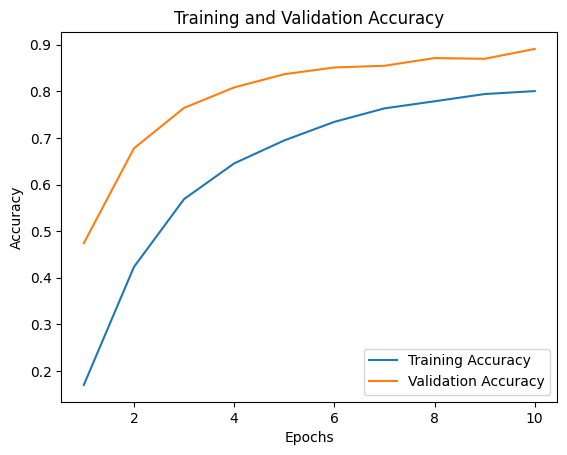

In [ ]:
import matplotlib.pyplot as plt
# Extract training and validation accuracy and loss from history
train_accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

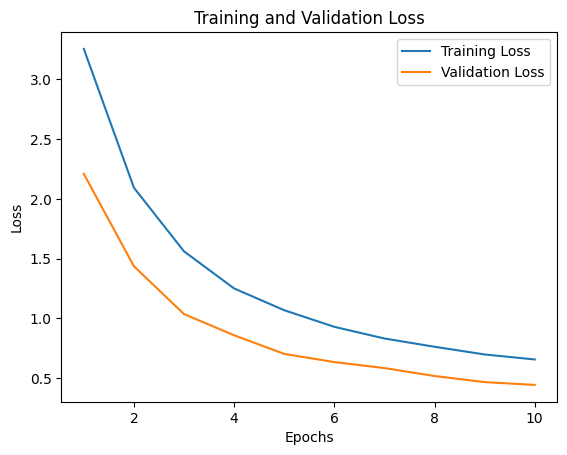

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Generate predictions on test data
predictions = inceptionv3_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)*100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')*100
recall = recall_score(true_classes, predicted_classes, average='weighted')*100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


9/9 [==============================] - 1s 105ms/step
Accuracy: 93.86617100371747
Precision: 94.14050488557201
Recall: 93.86617100371747
F1-score: 94.00313779462779


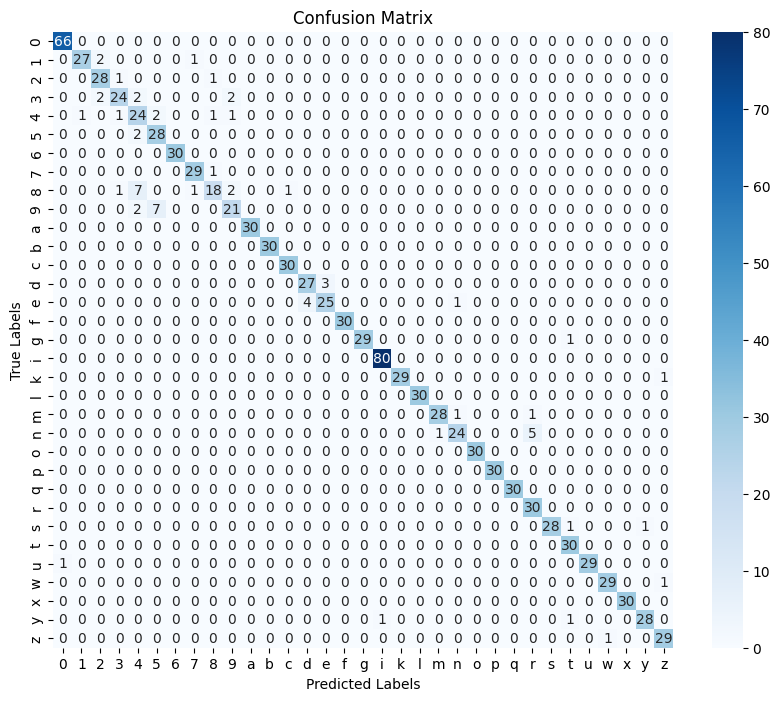

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 22ms/step


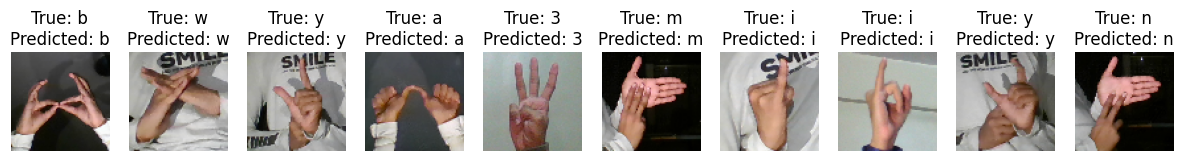

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = inceptionv3_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# MOBILENETV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
# Load the MobileNetV2 model pre-trained on ImageNet without the top layer
base_model2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Freeze the convolutional layers
base_model2.trainable = False
# Print model summary
base_model2.summary()

9406464/9406464 [==============================] - 2s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 38, 38, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 38, 38, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

In [ ]:
MobileNetV2_model = models.Sequential([
    base_model2,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(33, activation='softmax')
])

In [ ]:
MobileNetV2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 3, 3, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_2 (Flatten)         (None, 11520)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               5898752   
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 33)                16929     
                                                                 
Total params: 8173665 (31.18 MB)
Trainable params: 5915681 (22.57 MB)
Non-trainable params: 2257984 (8.61 MB)
__________

In [ ]:
# Define parameters
classes = 33
epochs = 10
learning_rate = 0.0001

# Compile the model
MobileNetV2_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history2 = MobileNetV2_model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    shuffle=True)

Epoch 1/10
61/61 [==============================] - 18s 259ms/step - loss: 2.1577 - accuracy: 0.4656 - val_loss: 0.5813 - val_accuracy: 0.8388
Epoch 2/10
61/61 [==============================] - 15s 253ms/step - loss: 0.7471 - accuracy: 0.7714 - val_loss: 0.3416 - val_accuracy: 0.9013
Epoch 3/10
61/61 [==============================] - 15s 251ms/step - loss: 0.5247 - accuracy: 0.8429 - val_loss: 0.2485 - val_accuracy: 0.9334
Epoch 4/10
61/61 [==============================] - 16s 257ms/step - loss: 0.4256 - accuracy: 0.8603 - val_loss: 0.1941 - val_accuracy: 0.9427
Epoch 5/10
61/61 [==============================] - 16s 255ms/step - loss: 0.3695 - accuracy: 0.8832 - val_loss: 0.1774 - val_accuracy: 0.9468
Epoch 6/10
61/61 [==============================] - 15s 250ms/step - loss: 0.3177 - accuracy: 0.8984 - val_loss: 0.1369 - val_accuracy: 0.9582
Epoch 7/10
61/61 [==============================] - 16s 264ms/step - loss: 0.3120 - accuracy: 0.8994 - val_loss: 0.1511 - val_accuracy: 0.9556

In [ ]:
MobileNetV2_model.save('33-mobilenetv2-newisl.h5')

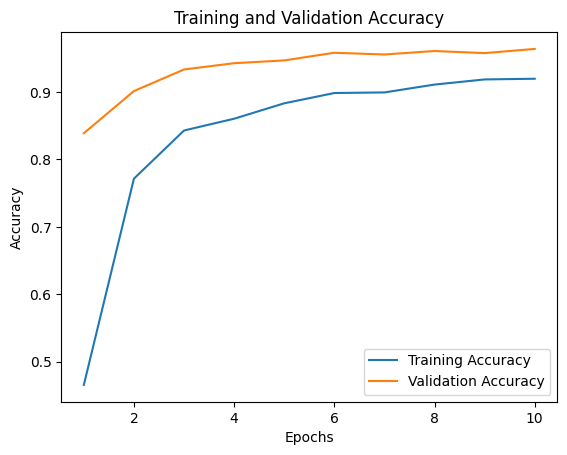

In [ ]:
import matplotlib.pyplot as plt
# Extract training and validation accuracy and loss from history
train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


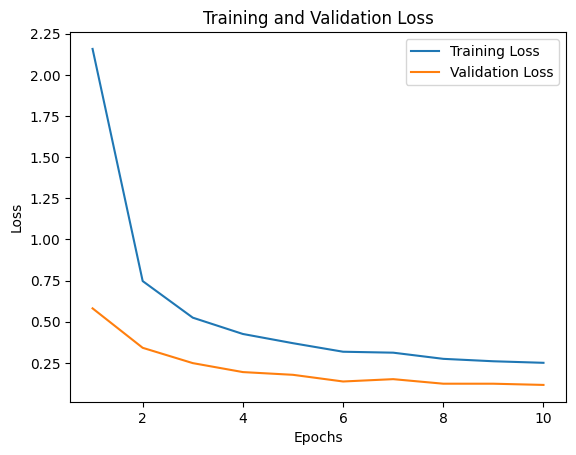

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Generate predictions on test data
predictions = MobileNetV2_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)*100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')*100
recall = recall_score(true_classes, predicted_classes, average='weighted')*100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


9/9 [==============================] - 2s 125ms/step
Accuracy: 97.58364312267658
Precision: 97.67871483754683
Recall: 97.58364312267658
F1-score: 97.63115583527451


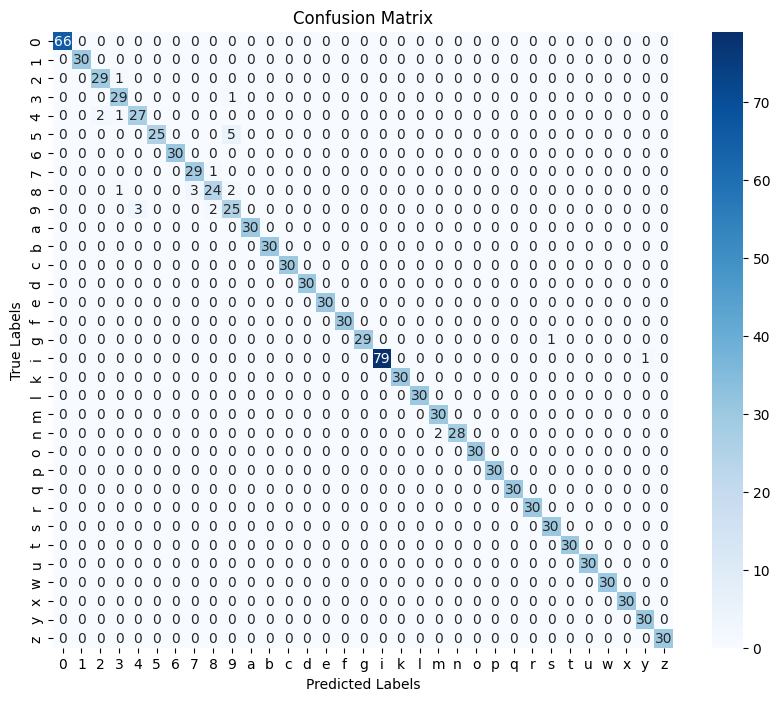

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 2s 2s/step


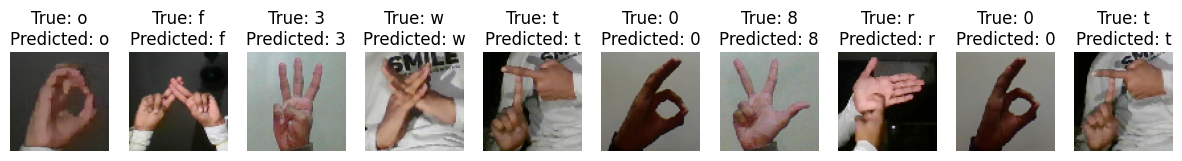

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = inceptionv3_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# RESNET50V2

In [ ]:
from tensorflow.keras.applications import ResNet50V2
# Load the ResNet50 model pre-trained on ImageNet without the top layer
base_model3 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Freeze the convolutional layers
base_model3.trainable = False
# Print model summary
base_model3.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 81, 81, 3)            0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 38, 38, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 40, 40, 64)           0         ['conv1_conv[0][0]']          
                                                                                         

In [ ]:
ResNet50V2_model = models.Sequential([
    base_model3,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(33, activation='softmax')
])

In [ ]:
ResNet50V2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 flatten_3 (Flatten)         (None, 18432)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 33)                16929     
                                                                 
Total params: 33019425 (125.96 MB)
Trainable params: 9454625 (36.07 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# Define parameters
classes = 33
epochs = 10
learning_rate = 0.0001

# Compile the model
ResNet50V2_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history3 = ResNet50V2_model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    shuffle=True)

Epoch 1/10
61/61 [==============================] - 20s 275ms/step - loss: 1.9125 - accuracy: 0.5518 - val_loss: 0.4433 - val_accuracy: 0.8626
Epoch 2/10
61/61 [==============================] - 16s 258ms/step - loss: 0.6676 - accuracy: 0.8004 - val_loss: 0.2898 - val_accuracy: 0.9122
Epoch 3/10
61/61 [==============================] - 16s 266ms/step - loss: 0.4477 - accuracy: 0.8620 - val_loss: 0.2004 - val_accuracy: 0.9349
Epoch 4/10
61/61 [==============================] - 17s 278ms/step - loss: 0.3782 - accuracy: 0.8806 - val_loss: 0.1776 - val_accuracy: 0.9437
Epoch 5/10
61/61 [==============================] - 17s 274ms/step - loss: 0.3200 - accuracy: 0.9009 - val_loss: 0.1549 - val_accuracy: 0.9509
Epoch 6/10
61/61 [==============================] - 17s 279ms/step - loss: 0.2723 - accuracy: 0.9159 - val_loss: 0.1195 - val_accuracy: 0.9613
Epoch 7/10
61/61 [==============================] - 17s 272ms/step - loss: 0.2538 - accuracy: 0.9180 - val_loss: 0.1155 - val_accuracy: 0.9576

In [ ]:
ResNet50V2_model.save('33-resnet50v2-newisl.h5')

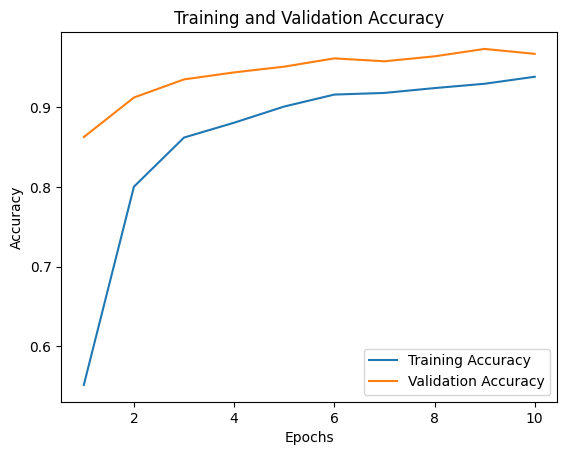

In [ ]:
import matplotlib.pyplot as plt
# Extract training and validation accuracy and loss from history
train_accuracy = history3.history['accuracy']
val_accuracy = history3.history['val_accuracy']
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


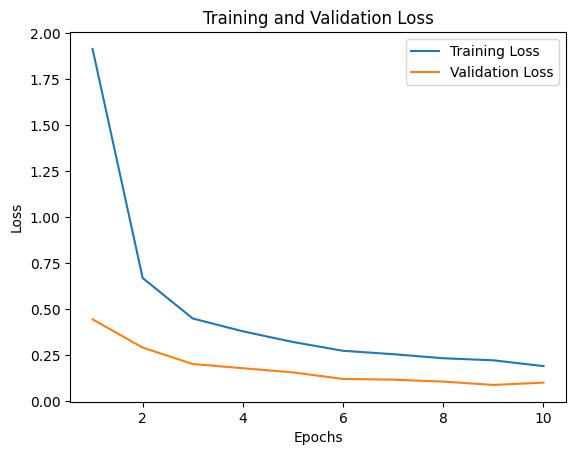

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Generate predictions on test data
predictions = ResNet50V2_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)*100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')*100
recall = recall_score(true_classes, predicted_classes, average='weighted')*100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


9/9 [==============================] - 3s 197ms/step
Accuracy: 98.69888475836431
Precision: 98.7826135370805
Recall: 98.69888475836431
F1-score: 98.74073139793714


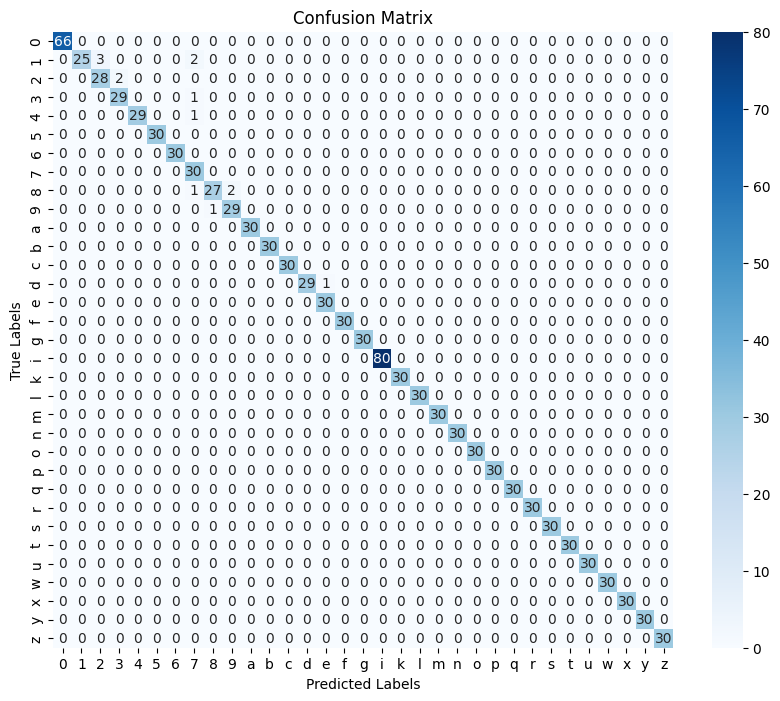

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 1s 997ms/step


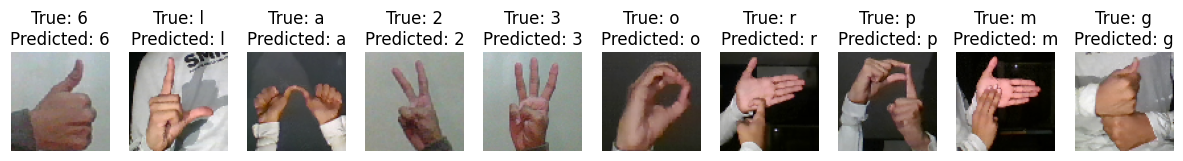

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = ResNet50V2_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# VGG19

In [ ]:
from tensorflow.keras.applications import VGG19
# Load the vgg19 model pre-trained on ImageNet without the top layer
base_model4 = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Freeze the convolutional layers
base_model4.trainable = False
# Print model summary
base_model4.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 75, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 37, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 37, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 37, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0     

In [ ]:
VGG19_model = models.Sequential([
    base_model4,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(33, activation='softmax')
])

In [ ]:
VGG19_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_23 (Dropout)        (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 33)                16929     
                                                                 
Total params: 21090401 (80.45 MB)
Trainable params: 1066017 (4.07 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [ ]:
# Define parameters
classes = 33
epochs = 10
learning_rate = 0.0001

# Compile the model
VGG19_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history4 = VGG19_model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    shuffle=True)

Epoch 1/10
61/61 [==============================] - 17s 260ms/step - loss: 0.5707 - accuracy: 0.8528 - val_loss: 0.4160 - val_accuracy: 0.9334
Epoch 2/10
61/61 [==============================] - 16s 256ms/step - loss: 0.5171 - accuracy: 0.8664 - val_loss: 0.3651 - val_accuracy: 0.9380
Epoch 3/10
61/61 [==============================] - 16s 256ms/step - loss: 0.4697 - accuracy: 0.8760 - val_loss: 0.3244 - val_accuracy: 0.9463
Epoch 4/10
61/61 [==============================] - 16s 258ms/step - loss: 0.4482 - accuracy: 0.8780 - val_loss: 0.3331 - val_accuracy: 0.9380
Epoch 5/10
61/61 [==============================] - 16s 256ms/step - loss: 0.4050 - accuracy: 0.8955 - val_loss: 0.2940 - val_accuracy: 0.9494
Epoch 6/10
61/61 [==============================] - 17s 277ms/step - loss: 0.3967 - accuracy: 0.8968 - val_loss: 0.2719 - val_accuracy: 0.9514
Epoch 7/10
61/61 [==============================] - 17s 279ms/step - loss: 0.3517 - accuracy: 0.9143 - val_loss: 0.2662 - val_accuracy: 0.9494

In [ ]:
VGG19_model.save('33-vgg19-newisl.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


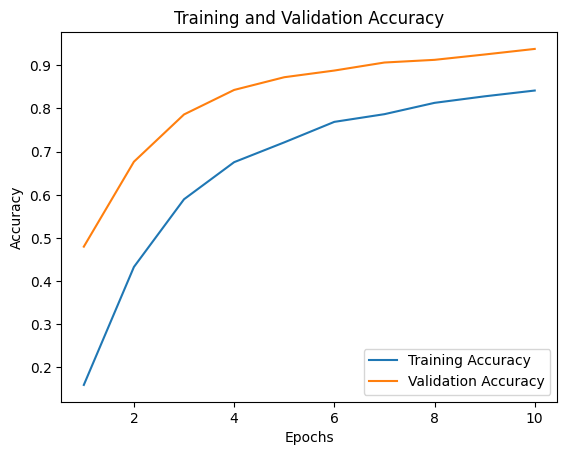

In [ ]:
import matplotlib.pyplot as plt
# Extract training and validation accuracy and loss from history
train_accuracy = history4.history['accuracy']
val_accuracy = history4.history['val_accuracy']
train_loss = history4.history['loss']
val_loss = history4.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


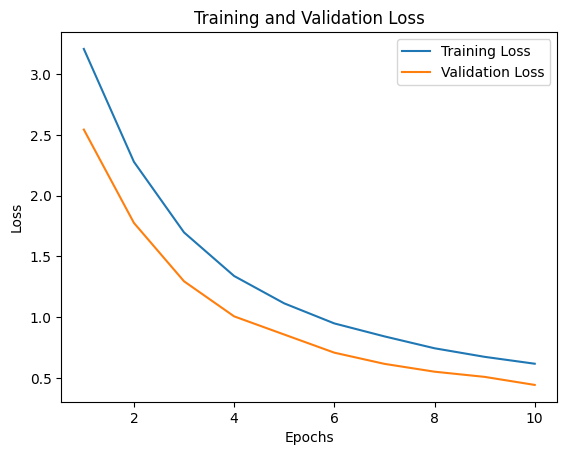

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Generate predictions on test data
predictions = VGG19_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)*100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')*100
recall = recall_score(true_classes, predicted_classes, average='weighted')*100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


9/9 [==============================] - 1s 106ms/step
Accuracy: 99.07063197026022
Precision: 99.1520052078872
Recall: 99.07063197026022
F1-score: 99.11130188663272


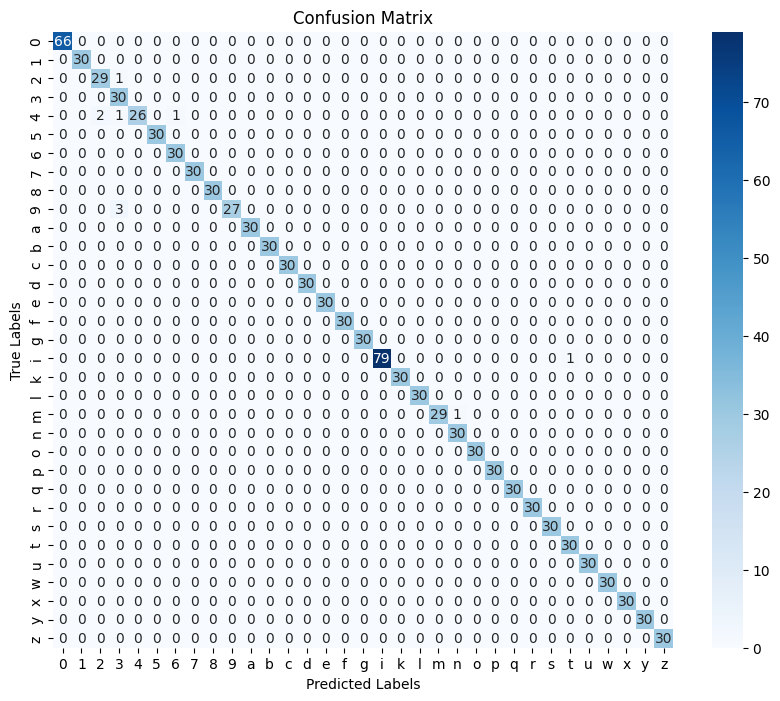

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 1s 733ms/step


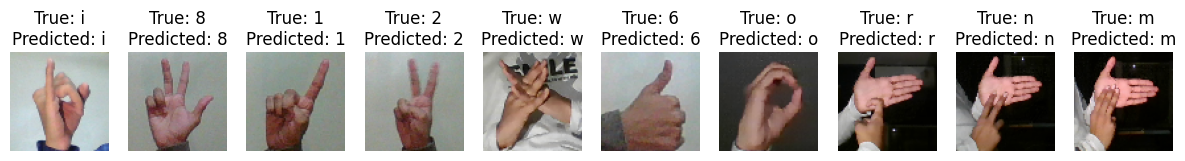

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = VGG19_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# MODEL COMPARISON

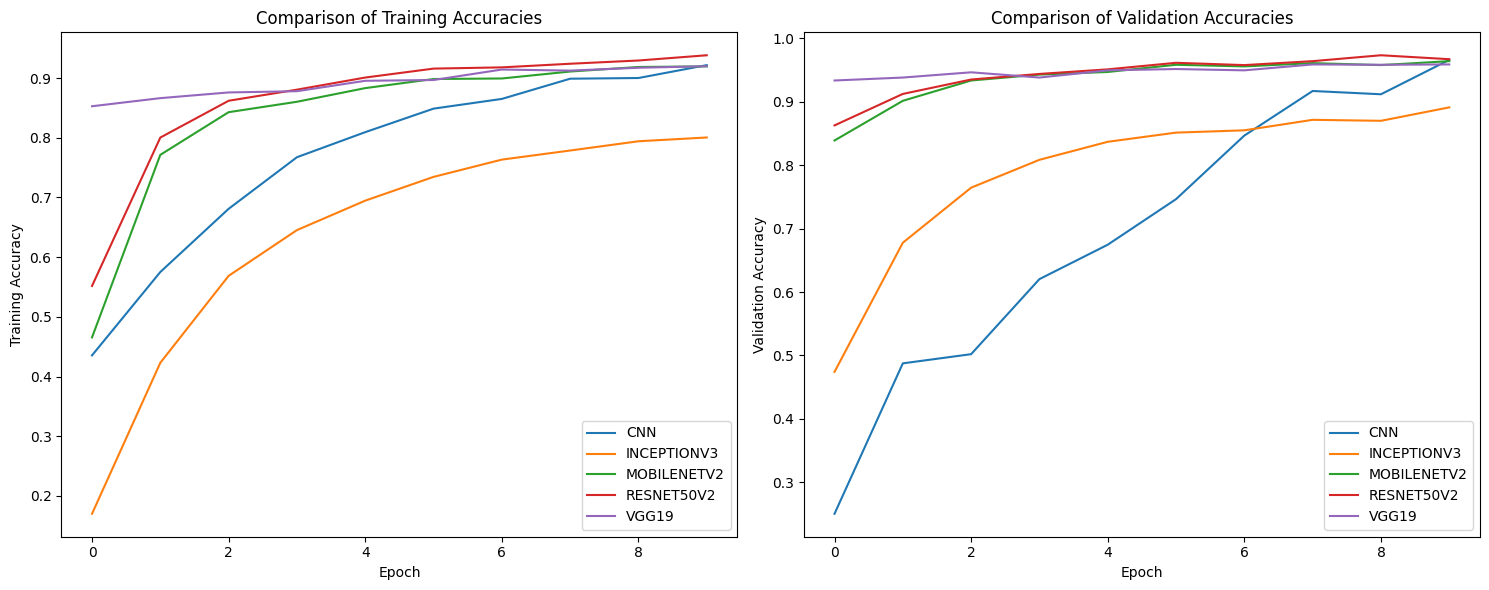

In [ ]:
import matplotlib.pyplot as plt

# Dictionary to store accuracies
train_accuracies = {}
validation_accuracies = {}

# Extract accuracies from history objects
train_accuracies['CNN'] = history.history['accuracy']
train_accuracies['INCEPTIONV3'] = history1.history['accuracy']
train_accuracies['MOBILENETV2'] = history2.history['accuracy']
train_accuracies['RESNET50V2'] = history3.history['accuracy']
train_accuracies['VGG19'] = history4.history['accuracy']

validation_accuracies['CNN'] = history.history['val_accuracy']
validation_accuracies['INCEPTIONV3'] = history1.history['val_accuracy']
validation_accuracies['MOBILENETV2'] = history2.history['val_accuracy']
validation_accuracies['RESNET50V2'] = history3.history['val_accuracy']
validation_accuracies['VGG19'] = history4.history['val_accuracy']

# Plotting the accuracies
plt.figure(figsize=(15, 6))

# Plot training accuracies
plt.subplot(1, 2, 1)
for model, acc in train_accuracies.items():
    plt.plot(acc, label=model)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Comparison of Training Accuracies')
plt.legend()

# Plot validation accuracies
plt.subplot(1, 2, 2)
for model, acc in validation_accuracies.items():
    plt.plot(acc, label=model)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.show()


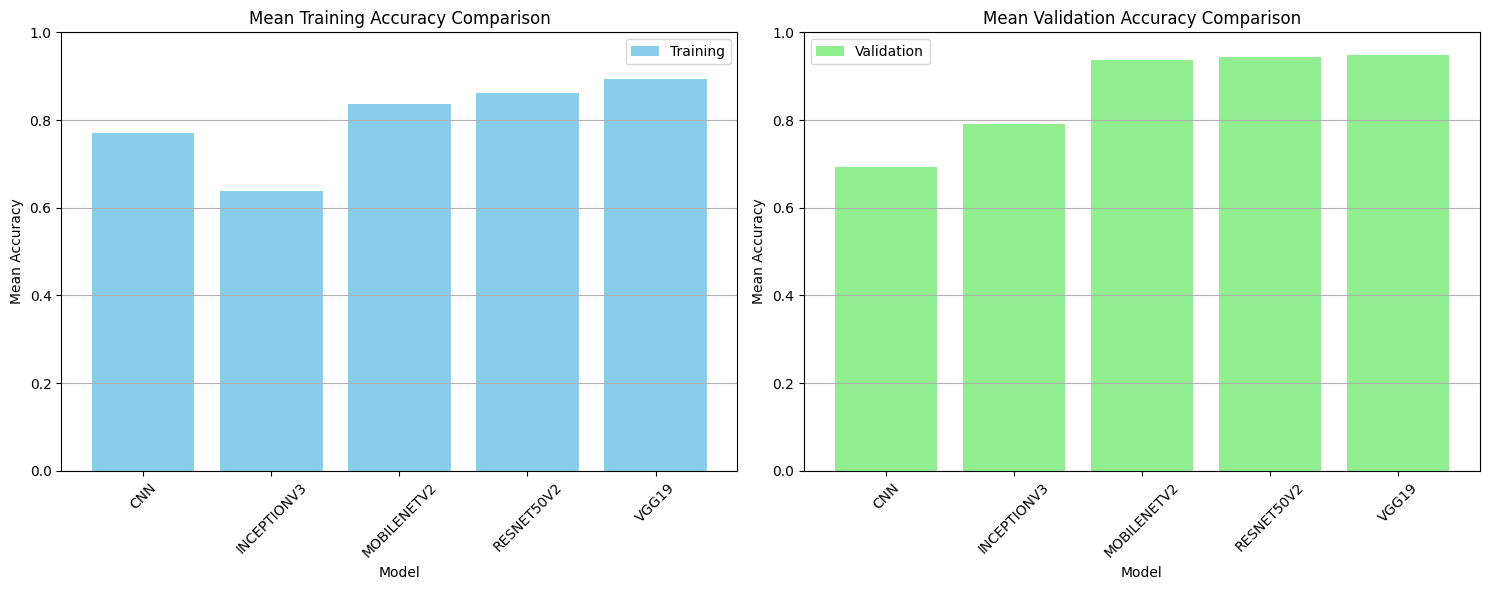

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dictionary to store accuracies
train_accuracies = {}
validation_accuracies = {}

# Extract accuracies from history objects
train_accuracies['CNN'] = history.history['accuracy']
train_accuracies['INCEPTIONV3'] = history1.history['accuracy']
train_accuracies['MOBILENETV2'] = history2.history['accuracy']
train_accuracies['RESNET50V2'] = history3.history['accuracy']
train_accuracies['VGG19'] = history4.history['accuracy']

validation_accuracies['CNN'] = history.history['val_accuracy']
validation_accuracies['INCEPTIONV3'] = history1.history['val_accuracy']
validation_accuracies['MOBILENETV2'] = history2.history['val_accuracy']
validation_accuracies['RESNET50V2'] = history3.history['val_accuracy']
validation_accuracies['VGG19'] = history4.history['val_accuracy']

# Calculate mean accuracies
train_means = [np.mean(acc) for acc in train_accuracies.values()]
validation_means = [np.mean(acc) for acc in validation_accuracies.values()]

# Plotting bar plots for mean training and validation accuracies
plt.figure(figsize=(15, 6))

# Plot mean training accuracies
plt.subplot(1, 2, 1)
plt.bar(np.arange(len(train_accuracies)), train_means, color='skyblue', label='Training')
plt.xlabel('Model')
plt.ylabel('Mean Accuracy')
plt.title('Mean Training Accuracy Comparison')
plt.xticks(np.arange(len(train_accuracies)), train_accuracies.keys(), rotation=45)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y')

# Plot mean validation accuracies
plt.subplot(1, 2, 2)
plt.bar(np.arange(len(validation_accuracies)), validation_means, color='lightgreen', label='Validation')
plt.xlabel('Model')
plt.ylabel('Mean Accuracy')
plt.title('Mean Validation Accuracy Comparison')
plt.xticks(np.arange(len(validation_accuracies)), validation_accuracies.keys(), rotation=45)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


9/9 [==============================] - 1s 100ms/step - loss: 0.0960 - accuracy: 0.9907


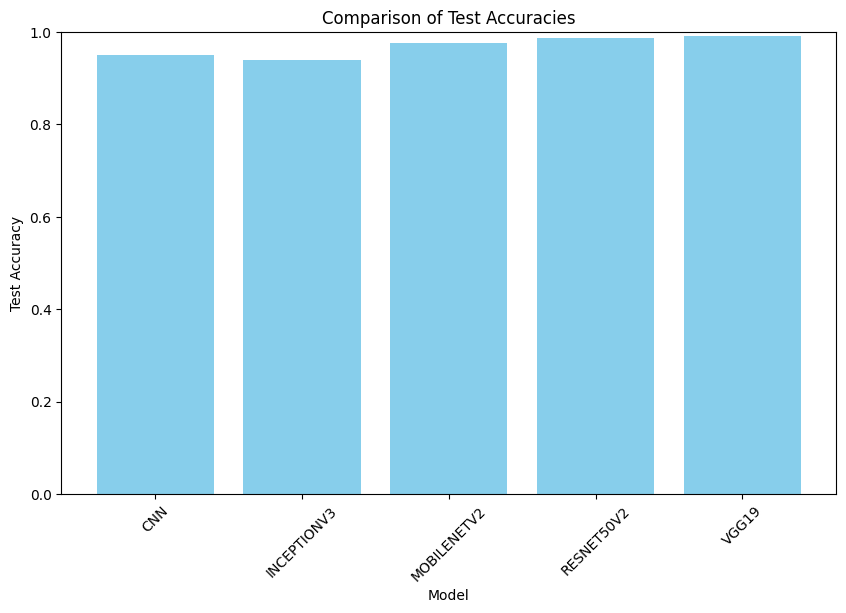

In [ ]:
# Dictionary to store test accuracies
test_accuracies = {}

# Evaluate each model on the test data
test_accuracies['CNN'] = cnn_model.evaluate(test_generator)[1]
test_accuracies['INCEPTIONV3'] = inceptionv3_model.evaluate(test_generator)[1]
test_accuracies['MOBILENETV2'] = MobileNetV2_model.evaluate(test_generator)[1]
test_accuracies['RESNET50V2'] = ResNet50V2_model.evaluate(test_generator)[1]
test_accuracies['VGG19'] = VGG19_model.evaluate(test_generator)[1]

# Plotting the test accuracies
plt.figure(figsize=(10, 6))
plt.bar(test_accuracies.keys(), test_accuracies.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Test Accuracies')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.show()
